### 1. 기본 설정

In [14]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tigramite import data_processing as pp
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI
import tigramite.plotting as tp

In [15]:
project_root = r"C:/Users/김현우/PycharmProjects/Causal_Project"
csv_name     = "monthly_df.csv"              # quarterly_df.csv 로 변경 가능
target_var   = "ASP_monthly"                 # 예측 타깃
tau_max      = 3                             # 최대 시차
alpha_level  = 0.05                          # 유의수준(p<α)
n_top        = 5                             # 상위 n개 부모 노드만 시각화
drop_cols    = ["DRAMDXI"]                   # 결측열 제거 목록

### 2. 데이터 로드, 전처리

In [16]:
path = os.path.join(project_root, "input", csv_name)
df   = (pd.read_csv(path, parse_dates=["TRADEDATE"])
          .set_index("TRADEDATE")
          .sort_index()
          .drop(columns=drop_cols))

scaled_df = pd.DataFrame(
    StandardScaler().fit_transform(df),
    index   = df.index,
    columns = df.columns
)
assert scaled_df.isna().sum().sum() == 0      # 최종 결측 확인

# DRAMDXI 열에 120 개의 결측치 확인 -> Tigramite 모델은 입력 배열에 NaN을 허용하지 않음 -> 해당 열을 제거하기

In [17]:
# Tigramite 전용 DataFrame
var_names = list(scaled_df.columns)
tiga_df   = pp.DataFrame(
    data      = scaled_df.to_numpy(),
    datatime  = scaled_df.index,
    var_names = var_names
)

### 3. PCMCI 실행

In [5]:
pcmci = PCMCI(dataframe=tiga_df,
              cond_ind_test=ParCorr(significance='analytic'),
              verbosity=0)

results = pcmci.run_pcmci(
    tau_max  = tau_max,
    pc_alpha = alpha_level
)
print("✓ PCMCI run complete")

✓ PCMCI run complete


### 4. 결과 요약 및 시각화

In [6]:
# 4-1. 유의 링크 표 간단 출력
pcmci.print_significant_links(
    p_matrix   = results['p_matrix'],
    val_matrix = results['val_matrix'],
    alpha_level= alpha_level,
    graph      = results['graph']
)


## Significant links at alpha = 0.05:

    Variable ASP_monthly has 16 link(s):
        (ASP_monthly -1): pval = 0.00000 | val =  0.753
        (.INX  0): pval = 0.00083 | val =  0.259 | unoriented link
        (MACRO US Interest Rate -3): pval = 0.00360 | val = -0.227
        (HGc1 -2): pval = 0.00393 | val =  0.224
        (CN3YT=RR  0): pval = 0.00418 | val =  0.224 | unoriented link
        (PLc1 -2): pval = 0.00500 | val =  0.218
        (MACRO M2 Money Stock -2): pval = 0.00685 | val =  0.212
        (MACRO US Interest Rate  0): pval = 0.01254 | val = -0.196 | unoriented link
        (HGc1 -1): pval = 0.01963 | val = -0.182
        (MACRO Conference Board CHINA -2): pval = 0.03364 | val =  0.167
        (CN10YT=RR -2): pval = 0.03377 | val = -0.166
        (MACRO KR CCI -3): pval = 0.03359 | val =  0.166
        (MACRO US Interest Rate -2): pval = 0.04017 | val =  0.161
        (MACRO M2 Money Stock -3): pval = 0.04122 | val = -0.161
        (MACRO US CPI -3): pval = 0.04451 | v

In [8]:
# 4-3. 타겟 변수 중심 그래프
p_mat, val_mat, graph = (results[k] for k in ('p_matrix','val_matrix','graph'))
d       = len(var_names)
t_idx   = var_names.index(target_var)

In [9]:
# (a) 모든 시차 링크 중 상위 n_top
edges_all = [(i, lag, abs(val_mat[i, t_idx, lag]))
             for i in range(d) if i!=t_idx
             for lag in range(tau_max+1)
             if graph[i, t_idx, lag]=='-->' and p_mat[i, t_idx, lag]<alpha_level]

top_all = sorted(edges_all, key=lambda x: x[2], reverse=True)[:n_top]
idx_all = sorted({i for i,_,_ in top_all} | {t_idx})
g_all   = graph[np.ix_(idx_all, idx_all, range(tau_max+1))]
v_all   = val_mat[np.ix_(idx_all, idx_all, range(tau_max+1))]
names_all = [var_names[i] for i in idx_all]


<Figure size 1000x700 with 0 Axes>

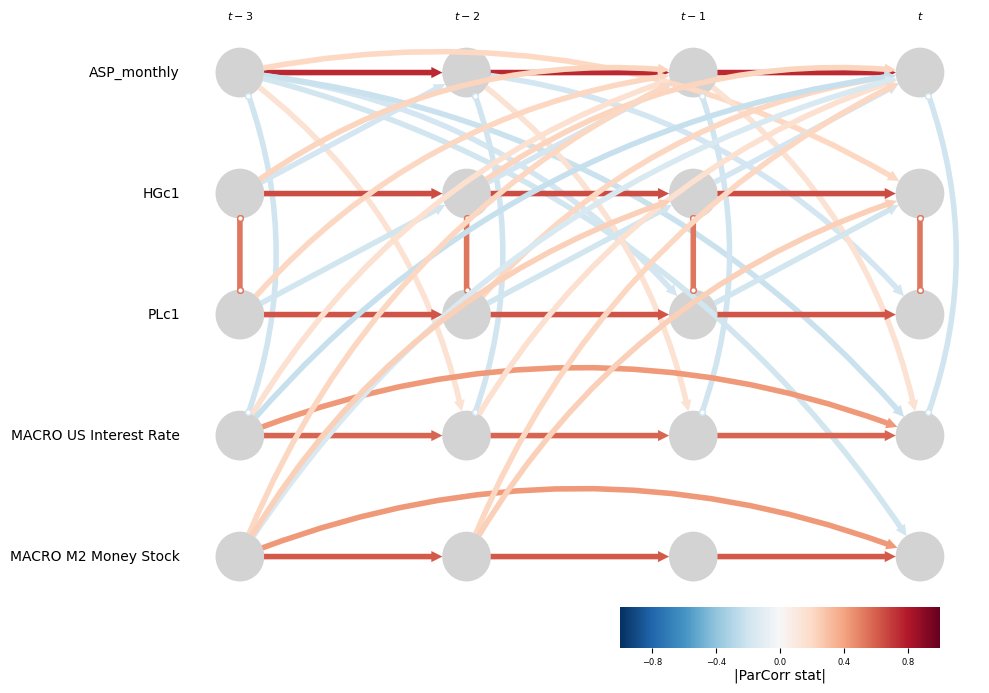

In [10]:
# (b) lag=0 링크 중 상위 n_top
edges_l0 = [(i, 0, abs(val_mat[i, t_idx, 0]))
            for i in range(d) if i!=t_idx
            if graph[i, t_idx, 0]=='-->' and p_mat[i, t_idx, 0]<alpha_level]

top_l0  = sorted(edges_l0, key=lambda x: x[2], reverse=True)[:n_top]
idx_l0  = sorted({i for i,_,_ in top_l0} | {t_idx})
g_l0    = graph[np.ix_(idx_l0, idx_l0, range(tau_max+1))]
v_l0    = val_mat[np.ix_(idx_l0, idx_l0, range(tau_max+1))]
names_l0 = [var_names[i] for i in idx_l0]

def show_ts_graph(g, v, names):
    plt.figure(figsize=(10, 7))
    tp.plot_time_series_graph(
        graph=g,
        val_matrix=v,
        var_names=names,
        figsize=(10, 7),
        link_colorbar_label="|ParCorr stat|"
    )
    plt.tight_layout()
    plt.show()

show_ts_graph(g_all, v_all, names_all)